### credit:
**Resnet code** is adopted and generalized from https://blog.csdn.net/weixin_43940163/article/details/103760294<br>
**Setup_seed code** is adopted from https://zhuanlan.zhihu.com/p/76472385

### Variations to try:
### 1. transform: 
`CenterCrop in eval?`<br>
If the most informative part of an image resides at the center, ignoring the marginal part can reduce noise.<br>
`RandomResizedCrop in train? What's the optimal scale?`<br>
It will largely enlarge the trainset with the model at a risk of underfitting.<br>
>default: none of them
### 2. train batchsize:
`8`, `16`, `32`, `64`, `128`<br>
(eval & test batchsize=64 is unchanged)<br>
>default: 64
### <font color=red>3. learning rate:</font>
with batchsize = 64,<br>
`SGD(lr=0.01)`<br>
`SGD(lr=0.025)`<br>
`SGD(lr=0.025)` + `StepLR(step_size=30, gamma=0.1)`<br>
`SGD(lr=0.025)` + `StepLR(step_size=20, gamma=0.5)`<br>
>default:<br>
`Adam(lr=0.001)` with **no** lr_schedular
### 4. regularization:
Adam weight_decay = `5e-4`, `1e-4`, `5e-5`, `1e-5`
>default: 1e-5

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy
import json

plt.ion()   # interactive mode

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
def load_data(TRAIN_BS):
    data_dir = '/kaggle/input/caltech101/Caltech101/Caltech101'
    data_transform = {
        'train': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomCrop((224,224), padding=16),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, hue=0.4),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'eval': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'eval', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['eval', 'test']}
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=TRAIN_BS, shuffle=True, num_workers=4)
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    return dataloaders, dataset_sizes, class_names, num_classes, device

In [5]:
# # show a batch of images
# def imshow(phase):
#     print(phase + ' images:')
#     inputs, classes = next(iter(dataloaders[phase]))
#     inp = torchvision.utils.make_grid(inputs)
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     title=[class_names[x] for x in classes]
#     plt.title(title)
#     plt.pause(0.001)

In [6]:
# ResNet with available versions: 18, 34, 50, 101,152

# block for small version of resnet
class Block_s(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Block_s,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out
    
# block for large version of resnet
class Block_l(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Block_l,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)  
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes*4, kernel_size=1, stride=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_planes*4)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out
        
        
class Resnet(nn.Module):
    def __init__(self, version=50, num_classes=101):
        self.v = version
        self.v_dic = {18:[2,2,2,2,512], 34:[3,4,6,3,512], 50:[3,4,6,3,2048], 101:[3,4,23,3,2048], 152:[3,8,36,3,2048]}
        self.in_planes = 64
        
        super(Resnet,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.conv2_x = self.make_layers(self.v_dic[version][0], stride=1, planes=64)
        self.conv3_x = self.make_layers(self.v_dic[version][1], stride=2, planes=128)
        self.conv4_x = self.make_layers(self.v_dic[version][2], stride=2, planes=256)
        self.conv5_x = self.make_layers(self.v_dic[version][3], stride=2, planes=512)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(self.v_dic[version][4], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def make_layers(self, repeat_times, stride, planes):
        if self.v < 50:
            downsample = None
            if stride!=1:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes)
                )
            layers=[]
            layers.append(Block_s(self.in_planes, planes, stride, downsample))
            self.in_planes = planes
            for i in range(repeat_times-1):
                layers.append(Block_s(self.in_planes, planes))
            return nn.Sequential(*layers)
            
        else:
            downsample = nn.Sequential(
                    nn.Conv2d(self.in_planes, planes*4,kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes*4)
            )
            layers=[]
            layers.append(Block_l(self.in_planes, planes, stride, downsample))
            self.in_planes = planes*4
            for i in range(repeat_times-1):
                layers.append(Block_l(self.in_planes, planes))
            return nn.Sequential(*layers)
    
    def forward(self,x):
        # conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # conv2_x
        x = self.maxPool(x)
        x = self.conv2_x(x)
        
        # conv3_x
        x = self.conv3_x(x)
        
        # conv4_x
        x = self.conv4_x(x)
        
        # conv5_x
        x = self.conv5_x(x)

        # average pool and fc
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x =self.fc(x)
        
        return x

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, sch=False):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
    lrs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    iters = len(dataloaders['train'])
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
#                         if sch:
#                             scheduler.step(epoch + step / iters)
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                    
            
            if sch and (phase == 'train'):
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            statistics[phase][0].append(epoch_loss)
            statistics[phase][1].append(float(epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    return model, statistics, lrs

In [8]:
def visualize_accuracy(num_epochs, statistics, fig_name):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.savefig(fig_name)

In [9]:
def test_model(model, details=False):  
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for count,data in enumerate(dataloaders['test']):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('test accuracy: %d %%' % (100 * correct / total))
    if details:
        acc_dic = {}
        for i in range(num_classes):
            acc = 100 * class_correct[i] / class_total[i]
            acc_dic[class_names[i]] = acc
            print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

cuda:0
Epoch 0/79
----------
train Loss: 5.7791 Acc: 0.0790
eval Loss: 4.5842 Acc: 0.0963

Epoch 1/79
----------
train Loss: 4.2208 Acc: 0.1058
eval Loss: 4.5352 Acc: 0.1561

Epoch 2/79
----------
train Loss: 4.1335 Acc: 0.1297
eval Loss: 4.5883 Acc: 0.1549

Epoch 3/79
----------
train Loss: 4.0635 Acc: 0.1457
eval Loss: 3.8547 Acc: 0.2073

Epoch 4/79
----------
train Loss: 3.8722 Acc: 0.1884
eval Loss: 3.6720 Acc: 0.2220

Epoch 5/79
----------
train Loss: 3.6480 Acc: 0.2170
eval Loss: 3.3946 Acc: 0.2659

Epoch 6/79
----------
train Loss: 3.4368 Acc: 0.2592
eval Loss: 3.1563 Acc: 0.3549

Epoch 7/79
----------
train Loss: 3.2117 Acc: 0.3085
eval Loss: 3.0542 Acc: 0.3878

Epoch 8/79
----------
train Loss: 2.9868 Acc: 0.3389
eval Loss: 2.8455 Acc: 0.3854

Epoch 9/79
----------
train Loss: 2.8043 Acc: 0.3700
eval Loss: 2.5783 Acc: 0.4305

Epoch 10/79
----------
train Loss: 2.6690 Acc: 0.3833
eval Loss: 3.7792 Acc: 0.4085

Epoch 11/79
----------
train Loss: 2.5153 Acc: 0.4200
eval Loss: 2.9

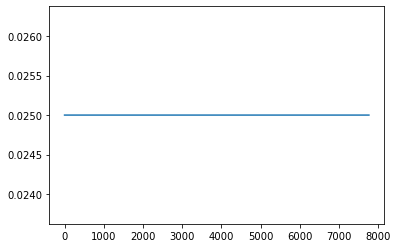

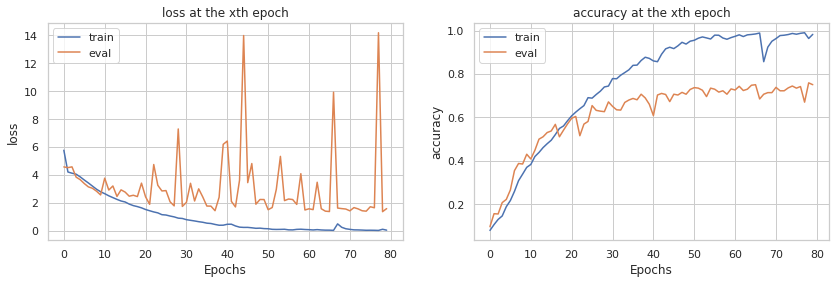

In [10]:
# set sch to False, no lr decay
setup_seed(20)
dataloaders, dataset_sizes, class_names, num_classes, device = load_data(64)
# imshow('train')

RN_0 = Resnet(50)
RN_0 = RN_0.to(device)
num_epochs = 80
criterion_0 = nn.CrossEntropyLoss()
optimizer_0 = optim.SGD(RN_0.parameters(), lr=0.025, momentum=0.9)
# cosine_lr_scheduler_0 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_0, T_0= int(1.3*num_epochs), T_mult=1, eta_min=0, last_epoch=-1)
exp_lr_scheduler_0 = torch.optim.lr_scheduler.StepLR(optimizer_0, step_size=30, gamma=0.1)

RN_0, statistics_0, lrs = train_model(RN_0, criterion_0, optimizer_0, exp_lr_scheduler_0, num_epochs=num_epochs, sch=False)

json.dump(statistics_0, open('lr_0.json', 'w'))
lr = np.array(lrs)[:,1]
plt.plot(np.arange(len(lr)), lr);
visualize_accuracy(num_epochs, statistics_0, 'lr_0.png')

torch.save(RN_0.state_dict(), '/kaggle/working/lr_0.pth')
test_model(RN_0)